# Augmented UKF (UKN) with step-change parameters + EKF/UKF baselines (PyTorch)

이 노트북은 아래를 **끝까지 한 번에 실행**할 수 있도록 구성된 예제/템플릿입니다.

- **Augmented UKF**: 상태 `x (3D)` + 파라미터 `θ (2D)` 를 합쳐 `z (5D)`로 추정  
- 파라미터는 **한 번 점프(step change) 후 계속 유지**하는 시나리오를 포함  
- **UKN(=UKF backbone + learnable Qx + GRU-adaptive Rt)** 를 학습하고,
- **EKF-aug / UKF-aug** 와 테스트에서 비교합니다.

> ⚠️ 이 예제는 “작동하는 기준 코드”를 제공하기 위한 synthetic 시스템입니다.  
> 실제 시스템에 적용하려면 `f(x,θ)` / `h(x)` / EKF Jacobian 부분만 교체하면 됩니다.


## 0) Imports / device
이 셀은 필요한 라이브러리를 불러오고, device(CPU/GPU)를 설정합니다.


In [1]:

import math
import os
from dataclasses import dataclass
from typing import Dict, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)


DEVICE: cuda


## 1) Config
시뮬레이션/학습/평가 설정값을 한 곳에 모아둡니다.


In [2]:

@dataclass
class Config:
    # Dimensions
    nx: int = 3
    nth: int = 2
    ny: int = 2
    nz: int = 5  # nx+nth

    # Simulation
    dt: float = 0.1
    T: int = 200
    n_train: int = 256
    n_val: int = 64
    n_test: int = 128

    # Parameter step-change (single jump, then hold)
    jump_frac: float = 0.10
    jump_window: Tuple[int,int] = (60, 140)

    # True noises
    Qx_true_diag: Tuple[float,float,float] = (1e-4, 1e-4, 5e-5)
    R_true_diag: Tuple[float,float] = (2e-3, 2e-3)

    # Parameter noise (relative)
    qth_base_rel: float = 1e-5

    # Jump detection via NIS
    jump_M: int = 2
    jump_J: int = 3
    nis_tau: float = 9.21  # chi2(df=2) 99%

    # UKN training
    epochs: int = 300
    batch_size: int = 32
    lr: float = 5e-3
    grad_clip: float = 1.0

    # UKN model
    gru_hidden: int = 32
    freeze_R_during_jump: bool = True

    # Jump logic toggle
    enable_jump_logic_train: bool = False
    enable_jump_logic_eval: bool = True

CFG = Config()
print(CFG)


Config(nx=3, nth=2, ny=2, nz=5, dt=0.1, T=200, n_train=256, n_val=64, n_test=128, jump_frac=0.1, jump_window=(60, 140), Qx_true_diag=(0.0001, 0.0001, 5e-05), R_true_diag=(0.002, 0.002), qth_base_rel=1e-05, jump_M=2, jump_J=3, nis_tau=9.21, epochs=300, batch_size=32, lr=0.005, grad_clip=1.0, gru_hidden=32, freeze_R_during_jump=True, enable_jump_logic_train=False, enable_jump_logic_eval=True)


## 2) Define synthetic system: f(x,θ), h(x)

예제로 3D 비선형 시스템을 정의합니다.

- `x=[p,v,b]`, `θ=[k,c]`  
- measurement `y=[p+0.1b, v]`  
- θ는 dynamics에만 들어가며, 한 번 점프 후 유지됩니다.

실제 시스템 적용 시 이 셀의 `f_x_theta`, `h_x`를 교체하세요.


In [3]:

def f_x_theta(x: torch.Tensor, th: torch.Tensor, dt: float) -> torch.Tensor:
    p, v, b = x[..., 0], x[..., 1], x[..., 2]
    k, c = th[..., 0], th[..., 1]

    p_next = p + dt * v
    v_next = v + dt * (-k * torch.sin(p) - c * v + 0.1 * torch.sin(b))
    b_next = b + dt * (0.05 * torch.cos(p))

    return torch.stack([p_next, v_next, b_next], dim=-1)

def h_x(x: torch.Tensor) -> torch.Tensor:
    p, v, b = x[..., 0], x[..., 1], x[..., 2]
    y1 = p + 0.1 * b
    y2 = v
    return torch.stack([y1, y2], dim=-1)


## 3) EKF Jacobians (augmented)

EKF baseline을 위해 augmented Jacobian을 제공합니다.

- `A = ∂f_aug/∂z` (5×5)  
- `H = ∂h/∂z` (2×5)


In [4]:

def jacobian_A_aug(z: torch.Tensor, dt: float) -> torch.Tensor:
    p, v, b = z[..., 0], z[..., 1], z[..., 2]
    k, c = z[..., 3], z[..., 4]

    A = torch.zeros(z.shape[:-1] + (5, 5), device=z.device, dtype=z.dtype)

    A[..., 0, 0] = 1.0
    A[..., 0, 1] = dt

    A[..., 1, 0] = dt * (-k * torch.cos(p))
    A[..., 1, 1] = 1.0 + dt * (-c)
    A[..., 1, 2] = dt * (0.1 * torch.cos(b))
    A[..., 1, 3] = dt * (-torch.sin(p))
    A[..., 1, 4] = dt * (-v)

    A[..., 2, 0] = dt * (-0.05 * torch.sin(p))
    A[..., 2, 2] = 1.0

    A[..., 3, 3] = 1.0
    A[..., 4, 4] = 1.0
    return A

def jacobian_H_aug(device=None, dtype=None) -> torch.Tensor:
    H = torch.zeros((2,5), dtype=dtype or torch.get_default_dtype(), device=device)
    H[0,0] = 1.0
    H[0,2] = 0.1
    H[1,1] = 1.0
    return H


## 4) Data generation (single step-change in θ)

훈련/검증/테스트 데이터셋을 생성합니다.


In [5]:

def simulate_dataset(cfg: Config, n_seq: int, seed: int = 0) -> Dict[str, np.ndarray]:
    rng = np.random.default_rng(seed)

    T = cfg.T
    dt = cfg.dt

    th_ref = np.array([1.0, 0.2], dtype=np.float64)

    Qx = np.diag(cfg.Qx_true_diag)
    R  = np.diag(cfg.R_true_diag)

    x_all = np.zeros((n_seq, T, cfg.nx), dtype=np.float64)
    th_all = np.zeros((n_seq, T, cfg.nth), dtype=np.float64)
    y_all = np.zeros((n_seq, T, cfg.ny), dtype=np.float64)
    jump_t_all = np.zeros((n_seq,), dtype=np.int64)

    for n in range(n_seq):
        x0 = np.array([0.2, 0.0, 0.1], dtype=np.float64) + rng.normal(0, 0.05, size=(cfg.nx,))
        th0 = th_ref * (1.0 + rng.normal(0, 0.03, size=(cfg.nth,)))

        t_jump = rng.integers(cfg.jump_window[0], cfg.jump_window[1])
        jump_t_all[n] = t_jump

        sign = rng.choice([-1.0, 1.0], size=(cfg.nth,))
        th_jump = th0 * (1.0 + sign * cfg.jump_frac)

        x = x0.copy()
        th = th0.copy()

        for t in range(T):
            if t == t_jump:
                th = th_jump.copy()

            x_t = torch.tensor(x, dtype=torch.float64)
            th_t = torch.tensor(th, dtype=torch.float64)
            x_next = f_x_theta(x_t, th_t, dt).cpu().numpy()
            x_next = x_next + rng.multivariate_normal(np.zeros(cfg.nx), Qx)

            y = h_x(torch.tensor(x_next, dtype=torch.float64)).cpu().numpy()
            y = y + rng.multivariate_normal(np.zeros(cfg.ny), R)

            x_all[n, t] = x_next
            th_all[n, t] = th
            y_all[n, t] = y

            x = x_next

    return {"x_true": x_all, "th_true": th_all, "y_meas": y_all, "jump_t": jump_t_all, "th_ref": th_ref}

train_data = simulate_dataset(CFG, CFG.n_train, seed=1)
val_data   = simulate_dataset(CFG, CFG.n_val, seed=2)
test_data  = simulate_dataset(CFG, CFG.n_test, seed=3)

print("train shapes:", train_data["x_true"].shape, train_data["y_meas"].shape)


train shapes: (256, 200, 3) (256, 200, 2)


## 5) UT helpers (sigma points, mean/cov, cross-cov) + SPD helpers

In [6]:

def chol_psd(P: torch.Tensor, jitter: float = 1e-6, max_tries: int = 8) -> torch.Tensor:
    # 1) 대칭화(수치오차로 비대칭 되는 것 방지)
    P = 0.5 * (P + P.transpose(-1, -2))

    I = torch.eye(P.shape[-1], device=P.device, dtype=P.dtype)
    jit = jitter
    for _ in range(max_tries):
        try:
            return torch.linalg.cholesky(P + jit * I)
        except Exception:
            jit *= 10.0

    # 2) 마지막 fallback: eigenvalue clamp로 PSD 보정
    w, V = torch.linalg.eigh(P)
    w = torch.clamp(w, min=jitter)
    P_fix = V @ torch.diag_embed(w) @ V.transpose(-1, -2)
    return torch.linalg.cholesky(P_fix + jitter * I)



def sigma_points(mean: torch.Tensor, cov: torch.Tensor, gamma: float) -> torch.Tensor:
    if mean.dim() == 1:
        mean = mean.unsqueeze(0)
        cov = cov.unsqueeze(0)
        squeeze = True
    else:
        squeeze = False

    B, n = mean.shape
    S = gamma * chol_psd(cov)  # (B,n,n)
    Xi0 = mean.unsqueeze(1)
    cols = S.transpose(-1, -2)  # (B,n,n)
    Xi = torch.cat([Xi0, Xi0 + cols, Xi0 - cols], dim=1)
    return Xi.squeeze(0) if squeeze else Xi

def ut_weights(n: int, alpha: float = 1e-3, beta: float = 2.0, kappa: float = 0.0):
    lam = alpha**2 * (n + kappa) - n
    c = n + lam
    Wm = torch.full((2*n+1,), 0.5/c, dtype=torch.get_default_dtype(), device=DEVICE)
    Wc = torch.full((2*n+1,), 0.5/c, dtype=torch.get_default_dtype(), device=DEVICE)
    Wm[0] = lam / c
    Wc[0] = lam / c + (1 - alpha**2 + beta)
    gamma = math.sqrt(c)
    return Wm, Wc, gamma

def ut_mean_cov(Xi: torch.Tensor, Wm: torch.Tensor, Wc: torch.Tensor):
    mean = (Xi * Wm.view(1, -1, 1)).sum(dim=1)
    d = Xi - mean.unsqueeze(1)
    cov = torch.einsum("bln,blm,l->bnm", d, d, Wc)
    return mean, cov

def ut_cross_cov(Xi: torch.Tensor, Yi: torch.Tensor, x_mean: torch.Tensor, y_mean: torch.Tensor, Wc: torch.Tensor):
    dx = Xi - x_mean.unsqueeze(1)
    dy = Yi - y_mean.unsqueeze(1)
    return torch.einsum("bln,blm,l->bnm", dx, dy, Wc)

def inv_via_cholesky(S: torch.Tensor) -> torch.Tensor:
    L = chol_psd(S)
    I = torch.eye(S.shape[-1], device=S.device, dtype=S.dtype).expand(S.shape[0], -1, -1)
    return torch.cholesky_solve(I, L)

def spd_from_diag(raw: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    s = torch.nn.functional.softplus(raw) + eps
    return torch.diag_embed(s**2)


## 6) Baseline EKF (augmented)

In [7]:

@torch.no_grad()
def ekf_aug_run(cfg: Config, y: torch.Tensor, z0: torch.Tensor, P0: torch.Tensor,
                Qx: torch.Tensor, R: torch.Tensor, th_ref: torch.Tensor,
                enable_jump_logic: bool = True):
    B, T, _ = y.shape
    H = jacobian_H_aug(device=y.device, dtype=y.dtype)

    QxB = Qx.unsqueeze(0).expand(B, -1, -1) if Qx.dim() == 2 else Qx
    RB  = R.unsqueeze(0).expand(B, -1, -1)  if R.dim() == 2 else R

    z, P = z0, P0
    z_out, P_out = [], []

    consec = torch.zeros((B,), device=y.device, dtype=torch.int64)
    jump_count = torch.zeros((B,), device=y.device, dtype=torch.int64)

    sigma_base = cfg.qth_base_rel * th_ref.abs()
    Qth_base = torch.diag_embed(sigma_base**2).unsqueeze(0).expand(B, -1, -1)
    sigma_jump = (cfg.jump_frac / math.sqrt(cfg.jump_J)) * th_ref.abs()
    Qth_jump = torch.diag_embed(sigma_jump**2).unsqueeze(0).expand(B, -1, -1)

    for t in range(T):
        x = z[:, :3]
        th = z[:, 3:]
        x_pred = f_x_theta(x, th, cfg.dt)
        z_pred = torch.cat([x_pred, th], dim=-1)

        A = jacobian_A_aug(z, cfg.dt)

        Qth = Qth_base
        if enable_jump_logic:
            Qth = torch.where(jump_count.view(B,1,1) > 0, Qth_jump, Qth_base)

        Q_aug = torch.zeros((B,5,5), device=y.device, dtype=y.dtype)
        Q_aug[:, :3, :3] = QxB
        Q_aug[:, 3:, 3:] = Qth

        P_pred = A @ P @ A.transpose(-1,-2) + Q_aug

        y_pred = h_x(x_pred)
        e = y[:, t] - y_pred

        S_noR = H @ P_pred @ H.transpose(-1,-2)
        S = S_noR + RB
        Sinv = inv_via_cholesky(S)

        K = P_pred @ H.transpose(-1,-2) @ Sinv
        z = z_pred + torch.einsum("bmn,bn->bm", K, e)

        I = torch.eye(5, device=y.device, dtype=y.dtype).unsqueeze(0).expand(B, -1, -1)
        KH = K @ H
        P = (I - KH) @ P_pred @ (I - KH).transpose(-1,-2) + K @ RB @ K.transpose(-1,-2)

        if enable_jump_logic:
            nis = torch.einsum("bi,bij,bj->b", e, Sinv, e)
            exceed = nis > cfg.nis_tau
            consec = torch.where(exceed, consec + 1, torch.zeros_like(consec))
            trigger = consec >= cfg.jump_M
            jump_count = torch.where(trigger, torch.full_like(jump_count, cfg.jump_J), jump_count)
            consec = torch.where(trigger, torch.zeros_like(consec), consec)
            jump_count = torch.clamp(jump_count - 1, min=0)

        z_out.append(z); P_out.append(P)

    return torch.stack(z_out, dim=1), torch.stack(P_out, dim=1)


## 7) Baseline UKF (augmented)

In [8]:

@torch.no_grad()
def ukf_aug_run(cfg: Config, y: torch.Tensor, z0: torch.Tensor, P0: torch.Tensor,
                Qx: torch.Tensor, R: torch.Tensor, th_ref: torch.Tensor,
                enable_jump_logic: bool = True,
                ut_alpha: float = 1e-3, ut_beta: float = 2.0, ut_kappa: float = 0.0):
    B, T, _ = y.shape
    n = cfg.nz
    Wm, Wc, gamma = ut_weights(n, alpha=ut_alpha, beta=ut_beta, kappa=ut_kappa)
    Wm, Wc = Wm.to(y.device), Wc.to(y.device)

    H = jacobian_H_aug(device=y.device, dtype=y.dtype)

    QxB = Qx.unsqueeze(0).expand(B, -1, -1) if Qx.dim() == 2 else Qx
    RB  = R.unsqueeze(0).expand(B, -1, -1)  if R.dim() == 2 else R

    z, P = z0, P0
    z_out, P_out = [], []

    consec = torch.zeros((B,), device=y.device, dtype=torch.int64)
    jump_count = torch.zeros((B,), device=y.device, dtype=torch.int64)

    sigma_base = cfg.qth_base_rel * th_ref.abs()
    Qth_base = torch.diag_embed(sigma_base**2).unsqueeze(0).expand(B, -1, -1)
    sigma_jump = (cfg.jump_frac / math.sqrt(cfg.jump_J)) * th_ref.abs()
    Qth_jump = torch.diag_embed(sigma_jump**2).unsqueeze(0).expand(B, -1, -1)

    for t in range(T):
        Xi = sigma_points(z, P, gamma)  # (B,L,5)
        Xi_x, Xi_th = Xi[..., :3], Xi[..., 3:]
        X_pred = f_x_theta(Xi_x, Xi_th, cfg.dt)
        Zi_pred = torch.cat([X_pred, Xi_th], dim=-1)

        z_pred, P_pred_noQ = ut_mean_cov(Zi_pred, Wm, Wc)

        Qth = Qth_base
        if enable_jump_logic:
            Qth = torch.where(jump_count.view(B,1,1) > 0, Qth_jump, Qth_base)

        Q_aug = torch.zeros((B,5,5), device=y.device, dtype=y.dtype)
        Q_aug[:, :3, :3] = QxB
        Q_aug[:, 3:, 3:] = Qth
        P_pred = P_pred_noQ + Q_aug

        Yi = h_x(Zi_pred[..., :3])
        y_pred, S_noR = ut_mean_cov(Yi, Wm, Wc)
        Pzy = ut_cross_cov(Zi_pred, Yi, z_pred, y_pred, Wc)

        S = S_noR + RB
        Sinv = inv_via_cholesky(S)
        K = torch.einsum("bmn,bnk->bmk", Pzy, Sinv)

        e = y[:, t] - y_pred
        z = z_pred + torch.einsum("bmn,bn->bm", K, e)

        # I = torch.eye(5, device=y.device, dtype=y.dtype).unsqueeze(0).expand(B, -1, -1)
        # KH = K @ H
        # P = (I - KH) @ P_pred @ (I - KH).transpose(-1,-2) + K @ RB @ K.transpose(-1,-2)
        
        I = torch.eye(5, device=y.device, dtype=y.dtype).unsqueeze(0).expand(B, -1, -1)
        P = P_pred - K @ S @ K.transpose(-1, -2)   # S = S_noR + R
        P = 0.5 * (P + P.transpose(-1, -2))        # symmetrize
        P = P + 1e-9 * I                            # tiny jitter

        if enable_jump_logic:
            nis = torch.einsum("bi,bij,bj->b", e, Sinv, e)
            exceed = nis > cfg.nis_tau
            consec = torch.where(exceed, consec + 1, torch.zeros_like(consec))
            trigger = consec >= cfg.jump_M
            jump_count = torch.where(trigger, torch.full_like(jump_count, cfg.jump_J), jump_count)
            consec = torch.where(trigger, torch.zeros_like(consec), consec)
            jump_count = torch.clamp(jump_count - 1, min=0)

        z_out.append(z); P_out.append(P)

    return torch.stack(z_out, dim=1), torch.stack(P_out, dim=1)


## 8) UKN (learnable Qx + GRU-adaptive Rt)

In [9]:

class UKN(nn.Module):
    def __init__(self, cfg: Config, th_ref: np.ndarray):
        super().__init__()
        self.cfg = cfg
        self.qx_raw = nn.Parameter(torch.zeros(cfg.nx, dtype=torch.get_default_dtype()))

        # features: e(2), de(2), abs(e)(2), diag(P_pred_x)(3), diag(S_noR)(2) -> 11
        self.gru = nn.GRU(input_size=11, hidden_size=cfg.gru_hidden, batch_first=True)
        self.head = nn.Linear(cfg.gru_hidden, cfg.ny)
        self.uR0 = nn.Parameter(torch.zeros(cfg.ny, dtype=torch.get_default_dtype()))

        th_ref_t = torch.tensor(th_ref, device=DEVICE, dtype=torch.get_default_dtype())
        self.register_buffer("th_ref", th_ref_t)

        Wm, Wc, gamma = ut_weights(cfg.nz, alpha=1e-3, beta=2.0, kappa=0.0)
        self.register_buffer("Wm", Wm)
        self.register_buffer("Wc", Wc)
        self.gamma = gamma
        self.register_buffer("H_aug", jacobian_H_aug(device=DEVICE, dtype=torch.get_default_dtype()))

    def Qx(self, B: int, device) -> torch.Tensor:
        return spd_from_diag(self.qx_raw).to(device).unsqueeze(0).expand(B, -1, -1)

    def Qtheta_base_jump(self, B: int, device):
        sigma_base = self.cfg.qth_base_rel * self.th_ref.abs()
        Qth_base = torch.diag_embed(sigma_base**2).to(device).unsqueeze(0).expand(B, -1, -1)
        sigma_jump = (self.cfg.jump_frac / math.sqrt(self.cfg.jump_J)) * self.th_ref.abs()
        Qth_jump = torch.diag_embed(sigma_jump**2).to(device).unsqueeze(0).expand(B, -1, -1)
        return Qth_base, Qth_jump

    def forward(self, y: torch.Tensor, z0: torch.Tensor, P0: torch.Tensor, enable_jump_logic: bool = True):
        cfg = self.cfg
        device = y.device
        B, T, _ = y.shape
        Wm, Wc = self.Wm.to(device), self.Wc.to(device)
        gamma = self.gamma

        QxB = self.Qx(B, device)
        Qth_base, Qth_jump = self.Qtheta_base_jump(B, device)

        z, P = z0, P0
        uR = self.uR0.to(device).unsqueeze(0).expand(B, -1)
        h = torch.zeros((1, B, cfg.gru_hidden), device=device, dtype=y.dtype)

        consec = torch.zeros((B,), device=device, dtype=torch.int64)
        jump_count = torch.zeros((B,), device=device, dtype=torch.int64)

        z_list, P_list, Rt_diag_list = [], [], []
        e_prev = torch.zeros((B, cfg.ny), device=device, dtype=y.dtype)

        for t in range(T):
            Xi = sigma_points(z, P, gamma)
            Xi_x, Xi_th = Xi[..., :3], Xi[..., 3:]
            X_pred = f_x_theta(Xi_x, Xi_th, cfg.dt)
            Zi_pred = torch.cat([X_pred, Xi_th], dim=-1)

            z_pred, P_pred_noQ = ut_mean_cov(Zi_pred, Wm, Wc)

            Qth = Qth_base
            if enable_jump_logic:
                Qth = torch.where(jump_count.view(B,1,1) > 0, Qth_jump, Qth_base)

            Q_aug = torch.zeros((B,5,5), device=device, dtype=y.dtype)
            Q_aug[:, :3, :3] = QxB
            Q_aug[:, 3:, 3:] = Qth
            P_pred = P_pred_noQ + Q_aug

            Yi = h_x(Zi_pred[..., :3])
            y_pred, S_noR = ut_mean_cov(Yi, Wm, Wc)
            Pzy = ut_cross_cov(Zi_pred, Yi, z_pred, y_pred, Wc)

            e = y[:, t] - y_pred
            de = e - e_prev
            e_prev = e

            diagP_pred_x = torch.diagonal(P_pred[:, :3, :3], dim1=-2, dim2=-1)
            diagS_noR = torch.diagonal(S_noR, dim1=-2, dim2=-1)
            feat = torch.cat([e, de, e.abs(), diagP_pred_x, diagS_noR], dim=-1)

            out, h = self.gru(feat.unsqueeze(1), h)
            duR = self.head(out.squeeze(1))

            if cfg.freeze_R_during_jump and enable_jump_logic:
                duR = torch.where((jump_count > 0).unsqueeze(-1), torch.zeros_like(duR), duR)

            uR = uR + duR
            R_t = spd_from_diag(uR)
            Rt_diag_list.append(torch.diagonal(R_t, dim1=-2, dim2=-1))

            S = S_noR + R_t
            Sinv = inv_via_cholesky(S)
            K = torch.einsum("bmn,bnk->bmk", Pzy, Sinv)

            z = z_pred + torch.einsum("bmn,bn->bm", K, e)

            # I = torch.eye(5, device=device, dtype=y.dtype).unsqueeze(0).expand(B, -1, -1)
            # KH = K @ self.H_aug.to(device)
            # P = (I - KH) @ P_pred @ (I - KH).transpose(-1,-2) + K @ R_t @ K.transpose(-1,-2)

            I = torch.eye(5, device=device, dtype=y.dtype).unsqueeze(0).expand(B, -1, -1)
            P = P_pred - K @ S @ K.transpose(-1, -2)   # S = S_noR + R_t
            P = 0.5 * (P + P.transpose(-1, -2))
            P = P + 1e-9 * I

            if enable_jump_logic:
                nis = torch.einsum("bi,bij,bj->b", e, Sinv, e)
                exceed = nis > cfg.nis_tau
                consec = torch.where(exceed, consec + 1, torch.zeros_like(consec))
                trigger = consec >= cfg.jump_M
                jump_count = torch.where(trigger, torch.full_like(jump_count, cfg.jump_J), jump_count)
                consec = torch.where(trigger, torch.zeros_like(consec), consec)
                jump_count = torch.clamp(jump_count - 1, min=0)

            z_list.append(z); P_list.append(P)

        return {"z_filt": torch.stack(z_list, dim=1),
                "P_filt": torch.stack(P_list, dim=1),
                "Rt_diag": torch.stack(Rt_diag_list, dim=1)}


## 9) Training loop (UKN)

시뮬레이션 데이터이므로 ground truth가 있어 supervised MSE loss로 학습합니다.


In [10]:

def to_torch_batch(batch_np: Dict[str, np.ndarray], idx: np.ndarray, device=DEVICE):
    x = torch.tensor(batch_np["x_true"][idx], device=device)
    th = torch.tensor(batch_np["th_true"][idx], device=device)
    y = torch.tensor(batch_np["y_meas"][idx], device=device)
    z_true = torch.cat([x, th], dim=-1)
    return y, z_true

def init_filter_states(cfg: Config, B: int, th_ref: np.ndarray, device=DEVICE):
    x0 = torch.zeros((B, cfg.nx), device=device, dtype=torch.get_default_dtype())
    th0 = torch.tensor(th_ref, device=device, dtype=torch.get_default_dtype()).unsqueeze(0).expand(B, -1)
    z0 = torch.cat([x0, th0], dim=-1)
    P0 = torch.diag_embed(torch.tensor([0.5, 0.5, 0.5, 0.2, 0.2], device=device, dtype=torch.get_default_dtype())**2).expand(B, -1, -1)
    return z0, P0

ukn = UKN(CFG, train_data["th_ref"]).to(DEVICE)
opt = optim.Adam(ukn.parameters(), lr=CFG.lr)

train_losses, val_losses = [], []

for epoch in range(1, CFG.epochs + 1):
    ukn.train()
    perm = np.random.permutation(CFG.n_train)
    eloss, nb = 0.0, 0

    for i in range(0, CFG.n_train, CFG.batch_size):
        idx = perm[i:i+CFG.batch_size]
        B = len(idx)
        y_b, z_true_b = to_torch_batch(train_data, idx, device=DEVICE)
        z0, P0 = init_filter_states(CFG, B, train_data["th_ref"], device=DEVICE)

        out = ukn(y_b, z0, P0, enable_jump_logic=CFG.enable_jump_logic_train)
        z_hat = out["z_filt"]
        loss = torch.mean((z_hat - z_true_b)**2)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(ukn.parameters(), CFG.grad_clip)
        opt.step()

        eloss += loss.item()
        nb += 1

    train_losses.append(eloss / max(nb, 1))

    ukn.eval()
    with torch.no_grad():
        permv = np.random.permutation(CFG.n_val)
        vloss, vb = 0.0, 0
        for i in range(0, CFG.n_val, CFG.batch_size):
            idx = permv[i:i+CFG.batch_size]
            B = len(idx)
            y_b, z_true_b = to_torch_batch(val_data, idx, device=DEVICE)
            z0, P0 = init_filter_states(CFG, B, val_data["th_ref"], device=DEVICE)
            out = ukn(y_b, z0, P0, enable_jump_logic=CFG.enable_jump_logic_train)
            vloss += torch.mean((out["z_filt"] - z_true_b)**2).item()
            vb += 1
        val_losses.append(vloss / max(vb, 1))

    if epoch % 5 == 0 or epoch == 1:
        print(f"epoch {epoch:03d} | train {train_losses[-1]:.6e} | val {val_losses[-1]:.6e}")


epoch 001 | train 4.863583e-01 | val 4.784277e-01
epoch 005 | train 5.974895e-01 | val 5.044077e-01
epoch 010 | train 3.681093e-01 | val 1.941274e-01
epoch 015 | train 1.838796e-01 | val 3.556437e-01
epoch 020 | train 7.507623e-02 | val 4.946378e-02
epoch 025 | train 7.106022e-02 | val 3.463198e-02
epoch 030 | train 2.334285e-02 | val 2.417596e-02
epoch 035 | train 1.606885e-02 | val 1.602591e-02
epoch 040 | train 1.099293e-02 | val 1.110641e-02
epoch 045 | train 8.007055e-03 | val 8.105371e-03
epoch 050 | train 6.621443e-03 | val 6.832447e-03
epoch 055 | train 5.951608e-03 | val 6.307283e-03
epoch 060 | train 5.615986e-03 | val 6.089542e-03
epoch 065 | train 5.459941e-03 | val 5.997722e-03
epoch 070 | train 5.357439e-03 | val 5.669382e-03
epoch 075 | train 5.250599e-03 | val 5.519464e-03
epoch 080 | train 5.270615e-03 | val 5.744922e-03
epoch 085 | train 5.129939e-03 | val 5.431261e-03
epoch 090 | train 5.152746e-03 | val 5.573896e-03
epoch 095 | train 5.047778e-03 | val 5.350682e-03


## 10) Test evaluation + save results

In [11]:

ukn.eval()

y_test = torch.tensor(test_data["y_meas"], device=DEVICE)
x_true = torch.tensor(test_data["x_true"], device=DEVICE)
th_true = torch.tensor(test_data["th_true"], device=DEVICE)
z_true = torch.cat([x_true, th_true], dim=-1)

Btest = y_test.shape[0]
z0, P0 = init_filter_states(CFG, Btest, test_data["th_ref"], device=DEVICE)

Qx_true = torch.diag(torch.tensor(CFG.Qx_true_diag, device=DEVICE, dtype=torch.get_default_dtype()))
R_true  = torch.diag(torch.tensor(CFG.R_true_diag, device=DEVICE, dtype=torch.get_default_dtype()))
th_ref_t = torch.tensor(test_data["th_ref"], device=DEVICE, dtype=torch.get_default_dtype())

z_ekf, P_ekf = ekf_aug_run(CFG, y_test, z0, P0, Qx_true, R_true, th_ref_t, enable_jump_logic=CFG.enable_jump_logic_eval)
z_ukf, P_ukf = ukf_aug_run(CFG, y_test, z0, P0, Qx_true, R_true, th_ref_t, enable_jump_logic=CFG.enable_jump_logic_eval)
with torch.no_grad():
    out_ukn = ukn(y_test, z0, P0, enable_jump_logic=CFG.enable_jump_logic_eval)
    z_ukn, P_ukn, Rt_diag = out_ukn["z_filt"], out_ukn["P_filt"], out_ukn["Rt_diag"]

Z995 = 2.5758293035489004
diag_cov = lambda P: torch.diagonal(P, dim1=-2, dim2=-1)

e_ekf = z_ekf - z_true
e_ukf = z_ukf - z_true
e_ukn = z_ukn - z_true

ci_ekf = Z995 * torch.sqrt(torch.clamp(diag_cov(P_ekf), min=1e-12))
ci_ukf = Z995 * torch.sqrt(torch.clamp(diag_cov(P_ukf), min=1e-12))
ci_ukn = Z995 * torch.sqrt(torch.clamp(diag_cov(P_ukn), min=1e-12))

rmse_t_ekf = torch.sqrt(torch.mean(e_ekf**2, dim=(0,2)))
rmse_t_ukf = torch.sqrt(torch.mean(e_ukf**2, dim=(0,2)))
rmse_t_ukn = torch.sqrt(torch.mean(e_ukn**2, dim=(0,2)))

RESULTS_PATH = os.path.join(os.getcwd(), "ukn_augmented_stepchange_results.npz")
np.savez(
    RESULTS_PATH,
    train_loss=np.array(train_losses),
    val_loss=np.array(val_losses),
    z_true=z_true.detach().cpu().numpy(),
    z_ekf=z_ekf.detach().cpu().numpy(),
    z_ukf=z_ukf.detach().cpu().numpy(),
    z_ukn=z_ukn.detach().cpu().numpy(),
    ci_ekf=ci_ekf.detach().cpu().numpy(),
    ci_ukf=ci_ukf.detach().cpu().numpy(),
    ci_ukn=ci_ukn.detach().cpu().numpy(),
    rmse_t_ekf=rmse_t_ekf.detach().cpu().numpy(),
    rmse_t_ukf=rmse_t_ukf.detach().cpu().numpy(),
    rmse_t_ukn=rmse_t_ukn.detach().cpu().numpy(),
    jump_t=test_data["jump_t"],
    Rt_diag=Rt_diag.detach().cpu().numpy(),
)
print("Saved:", RESULTS_PATH)


Saved: c:\Users\minhy\Documents\Research\Unscented-KalmanNet\ukn_augmented_stepchange_results.npz


## 11) FINAL: Plotting (3 required plots)

1) UKN 트레이닝 커브  
2) 테스트 시퀀스 1개에서 상태/파라미터 에러 + 99% CI band  
3) 테스트 배치에서 시간에 따른 RMSE


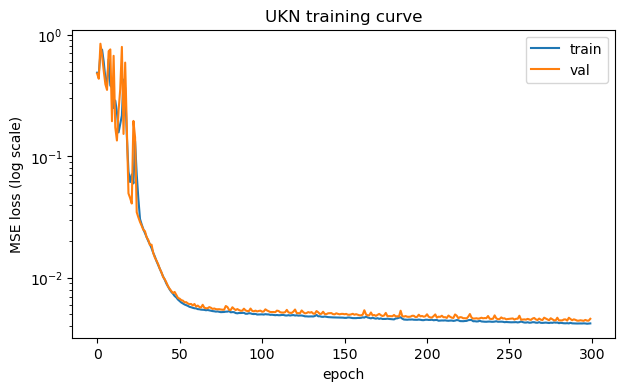

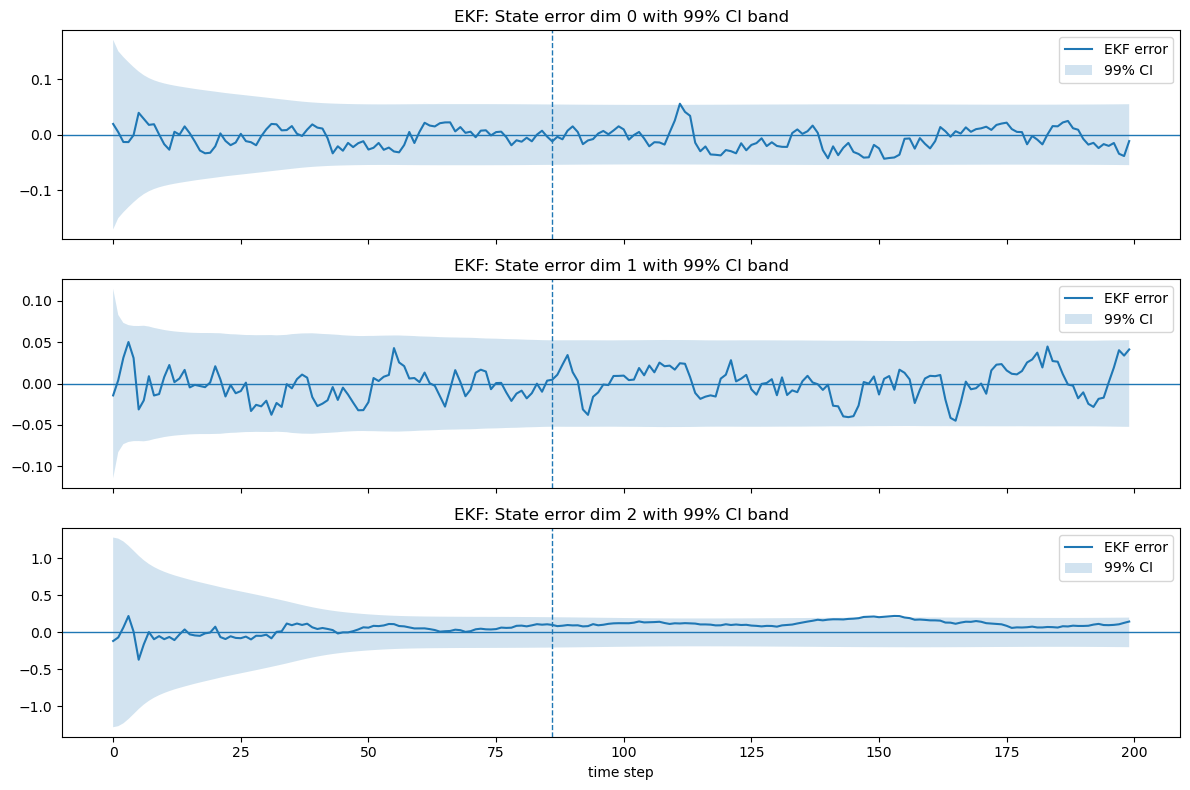

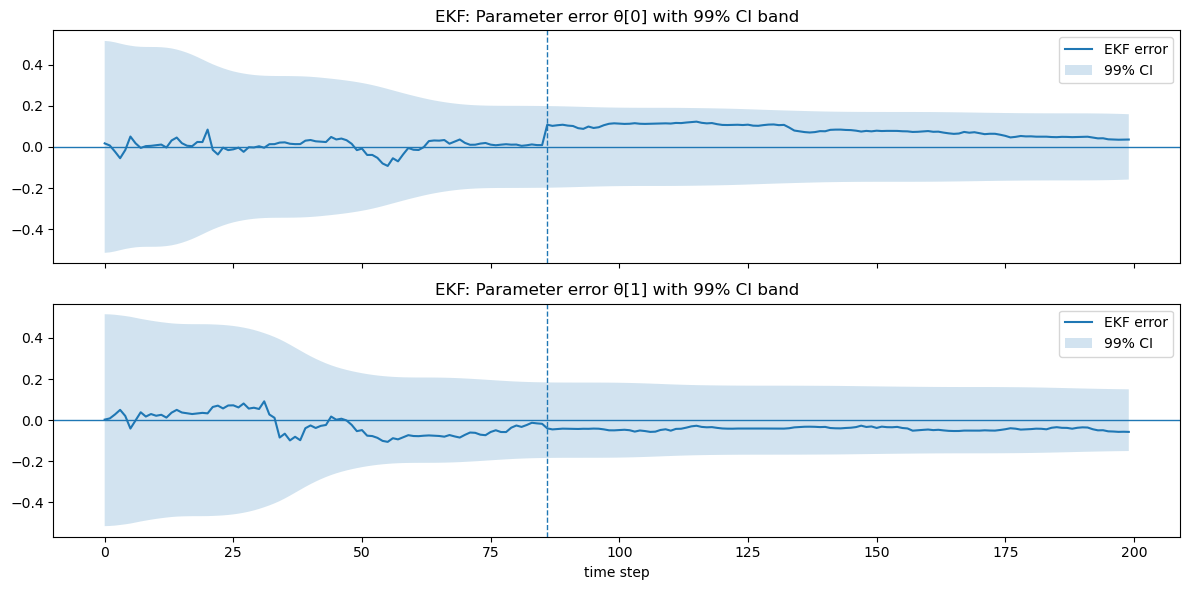

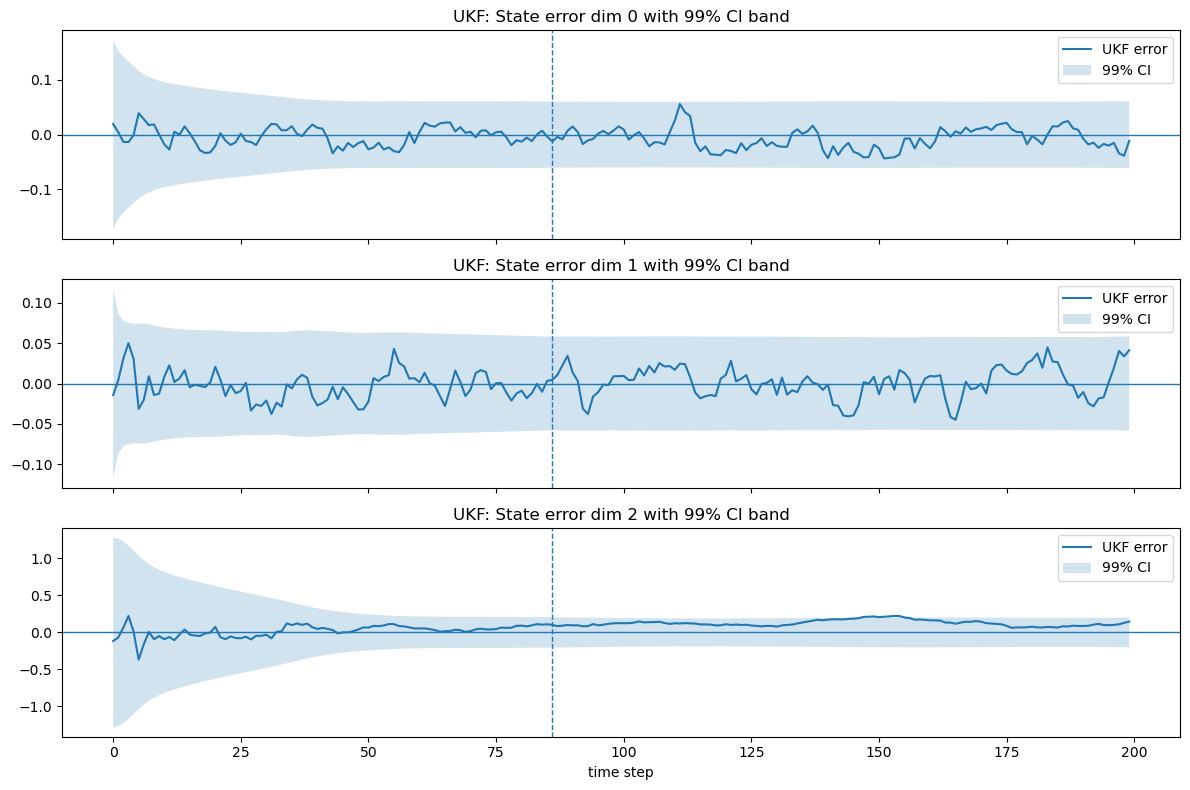

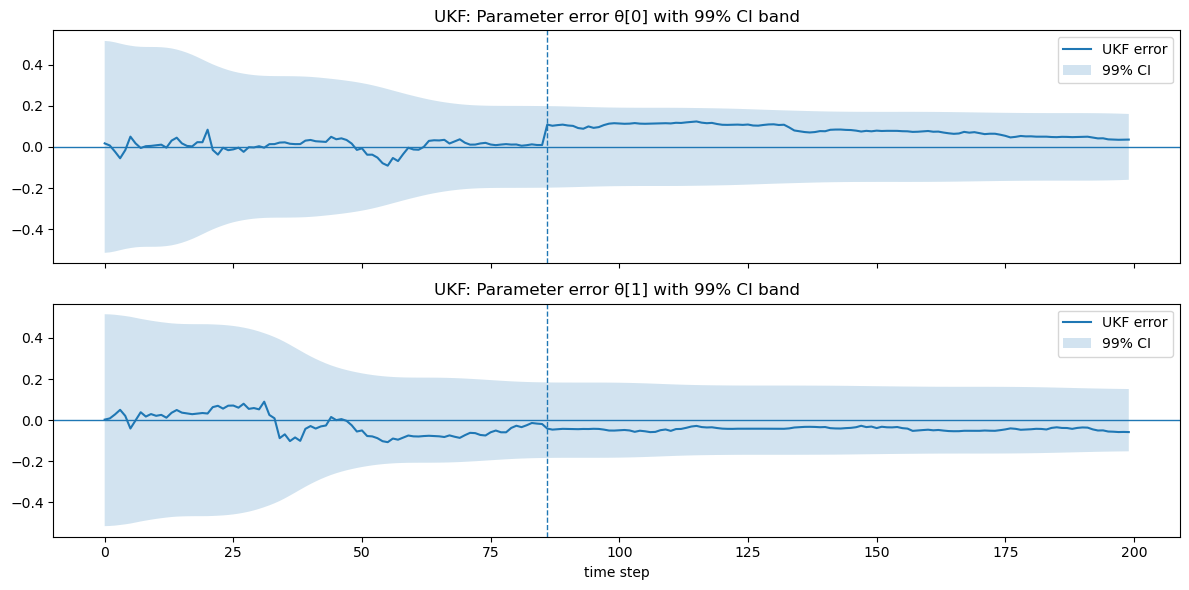

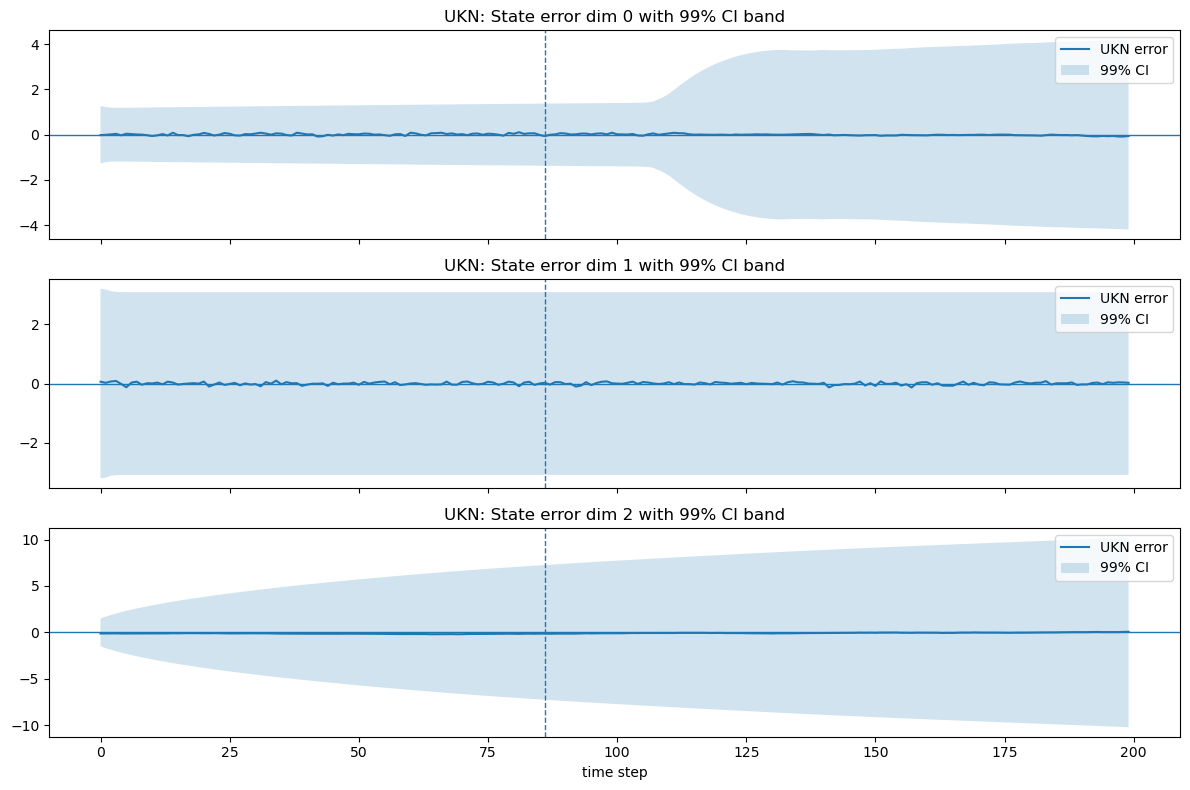

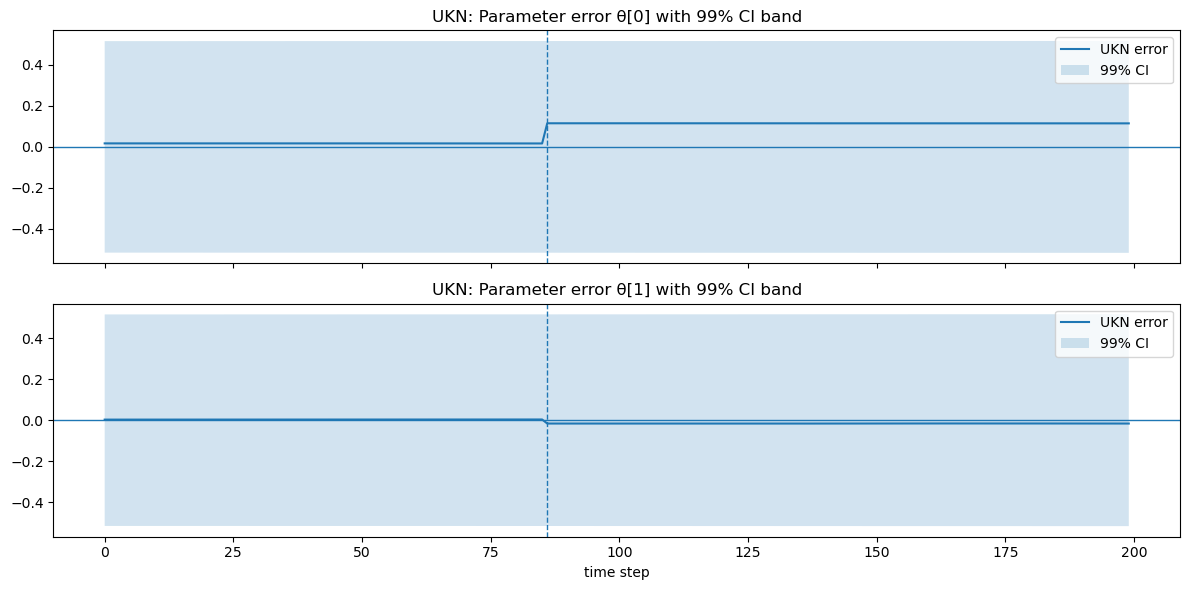

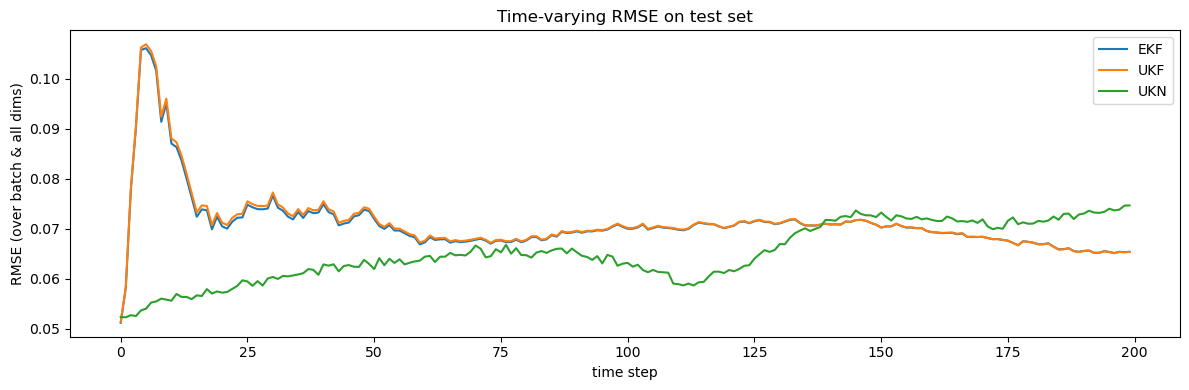

In [13]:

data = np.load(RESULTS_PATH, allow_pickle=True)
train_loss = data["train_loss"]
val_loss = data["val_loss"]

z_true = data["z_true"]
z_ekf  = data["z_ekf"]
z_ukf  = data["z_ukf"]
z_ukn  = data["z_ukn"]

ci_ekf = data["ci_ekf"]
ci_ukf = data["ci_ukf"]
ci_ukn = data["ci_ukn"]

rmse_t_ekf = data["rmse_t_ekf"]
rmse_t_ukf = data["rmse_t_ukf"]
rmse_t_ukn = data["rmse_t_ukn"]

jump_t = data["jump_t"]

seq_id = 0  # change if needed
t = np.arange(CFG.T)

# 1) Training curve
plt.figure(figsize=(7,4))
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="val")
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("MSE loss (log scale)")
plt.title("UKN training curve")
plt.legend()
plt.show()

def plot_err_ci(ax, err_dict, ci_dict, title):
    for name, e in err_dict.items():
        ax.plot(t, e, label=name)
        ci = ci_dict[name]
        ax.fill_between(t, -ci, ci, alpha=0.15)
    ax.axhline(0.0, linewidth=1.0)
    ax.set_title(title)

# 2) Error + CI bands (one sequence) — plot each method separately

seq_id = 0  # change if needed
t = np.arange(CFG.T)

err_ekf = z_ekf[seq_id] - z_true[seq_id]
err_ukf = z_ukf[seq_id] - z_true[seq_id]
err_ukn = z_ukn[seq_id] - z_true[seq_id]

ci_ekf_s = ci_ekf[seq_id]  # (T, D)
ci_ukf_s = ci_ukf[seq_id]
ci_ukn_s = ci_ukn[seq_id]

jt = jump_t[seq_id]

def plot_method_separate(method_name, err, ci):
    # --- States (0..2) ---
    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    for i in range(3):
        axes[i].plot(t, err[:, i], label=f"{method_name} error")
        axes[i].fill_between(t, -ci[:, i], ci[:, i], alpha=0.2, label="99% CI")
        axes[i].axhline(0.0, linewidth=1.0)
        axes[i].axvline(jt, linestyle="--", linewidth=1.0)
        axes[i].set_title(f"{method_name}: State error dim {i} with 99% CI band")
        axes[i].legend(loc="upper right")
    axes[-1].set_xlabel("time step")
    plt.tight_layout()
    plt.show()

    # --- Parameters (3..4) ---
    fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    for j in range(2):
        i = 3 + j
        axes[j].plot(t, err[:, i], label=f"{method_name} error")
        axes[j].fill_between(t, -ci[:, i], ci[:, i], alpha=0.2, label="99% CI")
        axes[j].axhline(0.0, linewidth=1.0)
        axes[j].axvline(jt, linestyle="--", linewidth=1.0)
        axes[j].set_title(f"{method_name}: Parameter error θ[{j}] with 99% CI band")
        axes[j].legend(loc="upper right")
    axes[-1].set_xlabel("time step")
    plt.tight_layout()
    plt.show()

# Plot separately
plot_method_separate("EKF", err_ekf, ci_ekf_s)
plot_method_separate("UKF", err_ukf, ci_ukf_s)
plot_method_separate("UKN", err_ukn, ci_ukn_s)


# 3) RMSE over time
plt.figure(figsize=(12,4))
plt.plot(t, rmse_t_ekf, label="EKF")
plt.plot(t, rmse_t_ukf, label="UKF")
plt.plot(t, rmse_t_ukn, label="UKN")
plt.xlabel("time step")
plt.ylabel("RMSE (over batch & all dims)")
plt.title("Time-varying RMSE on test set")
plt.legend()
plt.tight_layout()
plt.show()


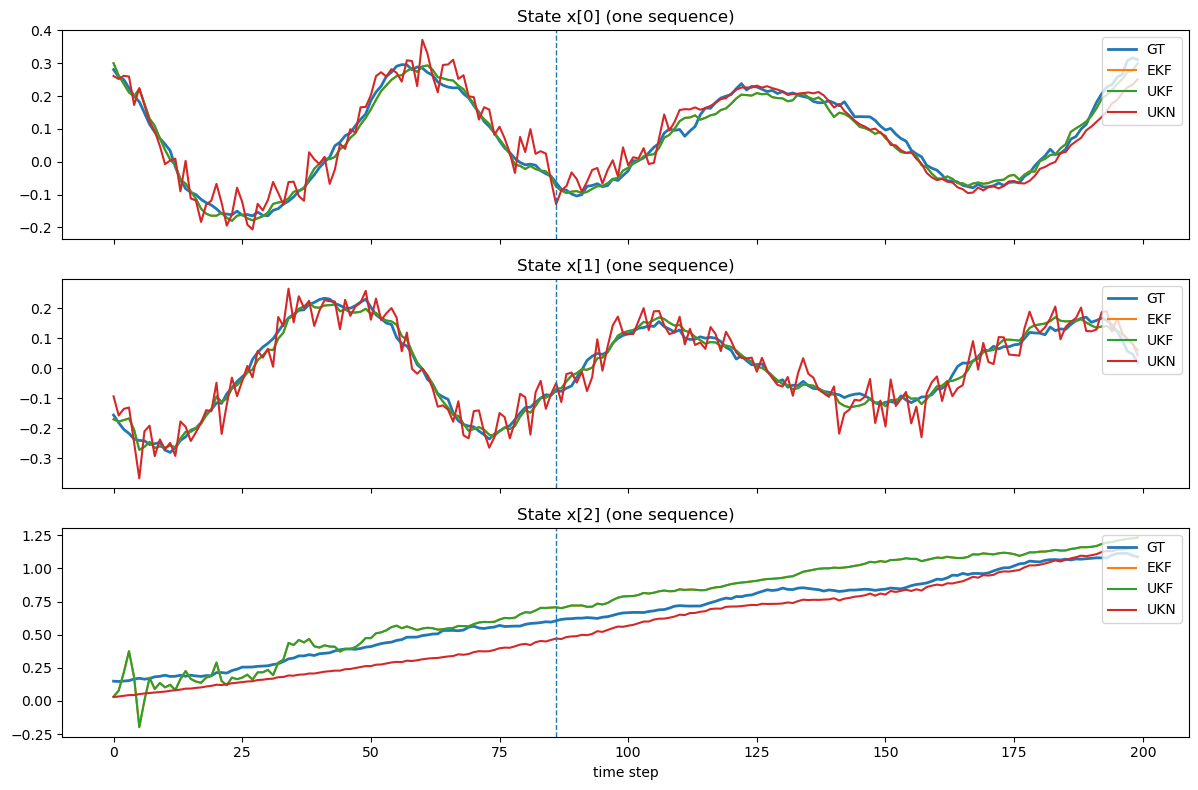

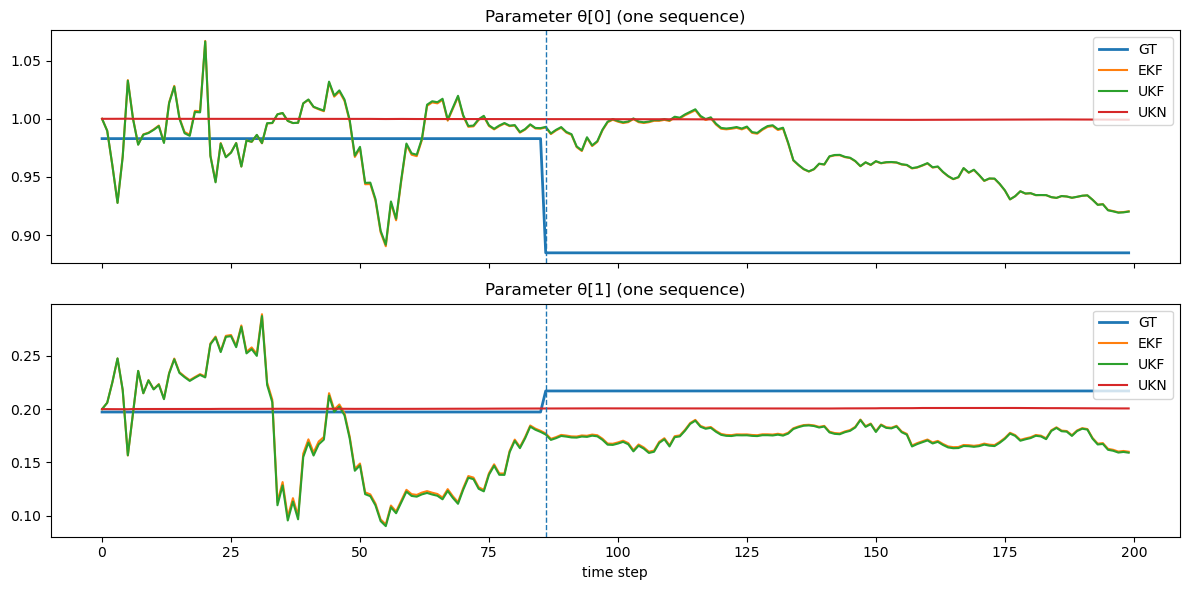

In [14]:
# One sequence: estimated states/params vs Ground Truth

seq_id = 0  # change if needed
t = np.arange(CFG.T)

zT = z_true[seq_id]   # (T,5)
zE = z_ekf[seq_id]
zU = z_ukf[seq_id]
zN = z_ukn[seq_id]

jt = jump_t[seq_id]

# ---- States (0..2) ----
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
for i in range(3):
    axes[i].plot(t, zT[:, i], label="GT", linewidth=2)
    axes[i].plot(t, zE[:, i], label="EKF")
    axes[i].plot(t, zU[:, i], label="UKF")
    axes[i].plot(t, zN[:, i], label="UKN")
    axes[i].axvline(jt, linestyle="--", linewidth=1.0)
    axes[i].set_title(f"State x[{i}] (one sequence)")
    axes[i].legend(loc="upper right")
axes[-1].set_xlabel("time step")
plt.tight_layout()
plt.show()

# ---- Parameters (3..4) ----
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
for j in range(2):
    i = 3 + j
    axes[j].plot(t, zT[:, i], label="GT", linewidth=2)
    axes[j].plot(t, zE[:, i], label="EKF")
    axes[j].plot(t, zU[:, i], label="UKF")
    axes[j].plot(t, zN[:, i], label="UKN")
    axes[j].axvline(jt, linestyle="--", linewidth=1.0)
    axes[j].set_title(f"Parameter θ[{j}] (one sequence)")
    axes[j].legend(loc="upper right")
axes[-1].set_xlabel("time step")
plt.tight_layout()
plt.show()
